In [1]:
import numpy as np
import pandas as pd
import vector
import os
import hist
import awkward as ak

vector.register_awkward()

from itertools import permutations

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# mplhep for CMS-style plots
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [3]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "Msd" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [4]:
events = pd.read_parquet(
    "/eos/uscms/store/user/cmantill/bbbb/matching/Sep19/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")
fjs = make_vector(events, "ak8FatJet")

In [12]:
np.array(events.keys())

array([('GenHiggsEta', 0), ('GenHiggsEta', 1), ('GenHiggsPhi', 0),
       ('GenHiggsPhi', 1), ('GenHiggsMass', 0), ('GenHiggsMass', 1),
       ('GenHiggsPt', 0), ('GenHiggsPt', 1), ('GenbEta', 0),
       ('GenbEta', 1), ('GenbEta', 2), ('GenbEta', 3), ('GenbPhi', 0),
       ('GenbPhi', 1), ('GenbPhi', 2), ('GenbPhi', 3), ('GenbMass', 0),
       ('GenbMass', 1), ('GenbMass', 2), ('GenbMass', 3), ('GenbPt', 0),
       ('GenbPt', 1), ('GenbPt', 2), ('GenbPt', 3),
       ('ak4JetHiggsMatch', 0), ('ak4JetHiggsMatch', 1),
       ('ak4JetHiggsMatch', 2), ('ak4JetHiggsMatch', 3),
       ('ak4JetHiggsMatch', 4), ('ak4JetHiggsMatch', 5),
       ('ak4JetHiggsMatchIndex', 0), ('ak4JetHiggsMatchIndex', 1),
       ('ak4JetHiggsMatchIndex', 2), ('ak4JetHiggsMatchIndex', 3),
       ('ak4JetHiggsMatchIndex', 4), ('ak4JetHiggsMatchIndex', 5),
       ('ak4JethadronFlavour', 0), ('ak4JethadronFlavour', 1),
       ('ak4JethadronFlavour', 2), ('ak4JethadronFlavour', 3),
       ('ak4JethadronFlavour', 4), ('

In [5]:
# ak4 jets matched to h1 and h2
h1ak4 = events["ak4JetHiggsMatchIndex"].to_numpy() == 0
h2ak4 = events["ak4JetHiggsMatchIndex"].to_numpy() == 1
num_ak4m2h1 = h1ak4.sum(axis=1)
num_ak4m2h2 = h2ak4.sum(axis=1)
h1m2ak4 = num_ak4m2h1 == 2
h2m2ak4 = num_ak4m2h2 == 2

# ak8 jets matched to h1 and h2
h1ak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy() == 0
h2ak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy() == 1
num_ak8m2h1 = h1ak8.sum(axis=1)
num_ak8m2h2 = h2ak8.sum(axis=1)
h1m1ak8 = num_ak8m2h1 == 1
h2m1ak8 = num_ak8m2h2 == 1

boosted = h1m1ak8 & h2m1ak8
resolved = (h1m2ak4 & h2m2ak4) & ~(boosted)
semi_resolved_h1 = h1m2ak4 & (h2m1ak8 & ~h2m2ak4) & ~(resolved) & ~(boosted)
semi_resolved_h2 = h2m2ak4 & (h1m1ak8 & ~h1m2ak4) & ~(resolved) & ~(boosted)
semi_resolved = semi_resolved_h1 | semi_resolved_h2
not_categorized = ~(resolved | boosted | semi_resolved)

## Classification from gen-level definition

We can classify events depending on matching into orthogonal categories:
- Boosted: 2 AK8 jets matched to H1 and H2, respectively
- Resolved: 4 AK4 jets matched to H1 and H2, 2 and 2, respectively - AND vetoing boosted
- Semi-resolved: "2 AK4 jets matched to H1/H2 and 1 AK8 jet matched to H2/H1 - AND vetoing boosted or resolved

In [6]:
print(f"Total number of signal events: {len(events)}")
print(f"2 AK8 jets matched to H1 and H2: {ak.sum(boosted)}")
print(f"4 AK4 jets matched to H1 and H2: {ak.sum(resolved)}")
print(f"2 AK4 jets matched to H1/H2 and 1 AK8 jet matched to H2/H1: {ak.sum(semi_resolved)}")
print(f"Outside of these categories: {ak.sum(not_categorized)}")
print(
    f"Sum of all: {ak.sum(not_categorized) + ak.sum(resolved) + ak.sum(boosted) + ak.sum(semi_resolved)}"
)

Total number of signal events: 95248
2 AK8 jets matched to H1 and H2: 12946
4 AK4 jets matched to H1 and H2: 25679
2 AK4 jets matched to H1/H2 and 1 AK8 jet matched to H2/H1: 7319
Outside of these categories: 49304
Sum of all: 95248


## Tasks for billy (gen-level)

Understand behavior at gen-level of `not-categorized events` (events that are not boosted, resolved or semi-resolved):
- plot gen MHH for all events (95248 events) and for each of the 4 categories above

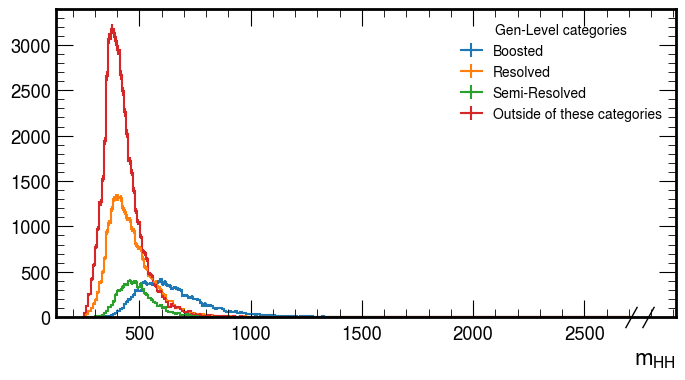

In [7]:
# calcualte m_HH for every event
mhh = (gen_higgs[:, 0] + gen_higgs[:, 1]).m

# bypass into each category
mhh_boosted = mhh[boosted]
mhh_resolved = mhh[resolved]
mhh_semi = mhh[semi_resolved]
mhh_out = mhh[not_categorized]

# start to plot, code modified on Christina's plot_h1h2_fj
bins = np.arange(mhh.min(), mhh.max(), 10)
var_axis = hist.axis.Variable(bins, name="var", label="variable")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

hist_mhh = hist.Hist(var_axis, cat_axis)
hist_mhh.fill(var=mhh_boosted, cat="boosted")
hist_mhh.fill(var=mhh_semi, cat="semi_resolved")
hist_mhh.fill(var=mhh_resolved, cat="resolved")
hist_mhh.fill(var=mhh_out, cat="non-categorized")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
hep.histplot(hist_mhh[{"cat": "boosted"}], ax=ax, label="Boosted")
hep.histplot(hist_mhh[{"cat": "resolved"}], ax=ax, label="Resolved")
hep.histplot(hist_mhh[{"cat": "semi_resolved"}], ax=ax, label="Semi-Resolved")
hep.histplot(hist_mhh[{"cat": "non-categorized"}], ax=ax, label="Outside of these categories")
leg = ax.legend(fontsize=10)
leg.set_title("Gen-Level categories", prop={"size": 10})
ax.set_xlabel(r"$m_{HH}$")
plt.show()

- further categorize `not-categorized events`:
  - what is the number of AK4 Jets matched to H1 and matched to H2 (1 + 2, 2 + 1, 0?. >2?)

In [8]:
def parse_2d_num_pairs(array, sym=False):
    if sym is True:
        for pair in array:
            print("")
            print(f"One H matched to {pair[0][0]} AK4 jets and {pair[1][0]} AK8 jets")
            print(f"The other H matched to {pair[0][1]} AK4 jets and {pair[1][1]} AK8 jets")
    else:
        for pair in array:
            print("")
            print(f"H1 matched to {pair[0][0]} AK4 jets and {pair[1][0]} AK8 jets")
            print(f"H2 matched to {pair[0][1]} AK4 jets and {pair[1][1]} AK8 jets")

    return

In [9]:
# e.g. number of ak4 jets matched to h1 and h2 for non-categorized events
num_ak4N8m2h_nc = (
    np.stack(
        [
            num_ak4m2h1[not_categorized],
            num_ak4m2h2[not_categorized],
            num_ak8m2h1[not_categorized],
            num_ak8m2h2[not_categorized],
        ],
        axis=1,
    )
    .reshape(-1, 2, 2)
    .tolist()
)

# store all recorded combinations of [[num_ak4m2H1, num_ak4m2H2], [num_ak8m2H1, num_ak8m2H2]]
pair_ak4N8m2h_nc = []

# loop from all num pairs constructed from the ooc events
for pair in num_ak4N8m2h_nc:
    if pair not in pair_ak4N8m2h_nc:
        pair_ak4N8m2h_nc.append(pair)

parse_2d_num_pairs(pair_ak4N8m2h_nc)


H1 matched to 2 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 3 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 1 AK8 jets

H1 matched to 3 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 0 AK4 jets and 0 AK8 jets
H2 matched to 2 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 1 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 3 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 1 AK8 jets

H1 matched to 0 AK4 jets and 0 AK8 jets
H2 matched to 1 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 0 AK8 jets
H2 matched to 0 AK4 jets and 0 AK8 jets

H1 matched to 1 AK4 jets and 1 AK8 jets
H2 matched to 0 AK4 jets and 0 AK8 jets

H1 matched to 2 AK4 jets an

In [10]:
# This cell is tryig to assume H1 and H2 is symmetric
# e.g. num_ak4m2HX = (2, 1) == (1, 2)
# the point is to not differentiate H1 and H2
# note that if ak4 pair is permutated, then ak8 pair should be permutated in the same way

# store all permutations of the recorded combinations of [[num_ak4m2H1, num_ak4m2H2], [num_ak8m2H1, num_ak8m2H2]]
perm_pair_ak4N8m2h_nc = []
# store unique combinations of [num_ak4m2HX, num_ak8m2HX]
unique_pair_ak4N8m2h_nc = []

# loop from all num pairs constructed from the ooc events
for pair in num_ak4N8m2h_nc:
    # if it doesn't match any permutation of the recorded unique pair
    if pair not in perm_pair_ak4N8m2h_nc:
        # add to the unique pair
        unique_pair_ak4N8m2h_nc.append(pair)
        # also add its permutations to the permutation list
        perm_pair_ak4N8m2h_nc.append(pair)
        perm_pair_ak4N8m2h_nc.append([pair[0][::-1], pair[1][::-1]])

parse_2d_num_pairs(unique_pair_ak4N8m2h_nc, sym=True)


One H matched to 2 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 3 AK4 jets and 0 AK8 jets
The other H matched to 2 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 0 AK8 jets
The other H matched to 2 AK4 jets and 1 AK8 jets

One H matched to 3 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 0 AK4 jets and 0 AK8 jets
The other H matched to 2 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 1 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 3 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 1 AK8 jets

One H matched to 0 AK4 jets and 0 AK8 jets
The other H matched to 1 AK4 jets and 0 AK8 jets

One H matched to 1 AK4 jets and 1 AK8 jets
The other H matched to 0 AK4 jets and 0 AK8 jets

One H matched to 2 AK4 jets and 1 AK8 jets
The other H matched to 0 A

In [11]:
# e.g. number of ak4 jets matched to h1 and h2 for non-categorized events
num_ak4m2h_nc = np.stack(
    [num_ak4m2h1[not_categorized], num_ak4m2h2[not_categorized]], axis=1
).tolist()

unique_pair_ak4m2h_nc = []
for pair in num_ak4m2h_nc:
    if (pair not in unique_pair_ak4m2h_nc) and (pair[::-1] not in unique_pair_ak4m2h_nc):
        unique_pair_ak4m2h_nc.append(pair)

print(unique_pair_ak4m2h_nc)

[[2, 1], [1, 1], [3, 2], [3, 1], [0, 2], [0, 1], [4, 1], [0, 0], [0, 3], [3, 3], [4, 2]]


  - what is the number of AK8 Jets matched to H1 and matched to H2 (1 + 2, 2 + 1, 0?. >2?)

In [12]:
num_ak8m2h_nc = np.stack(
    [num_ak8m2h1[not_categorized], num_ak8m2h2[not_categorized]], axis=1
).tolist()

unique_pair_ak8m2h_nc = []
for pair in num_ak8m2h_nc:
    if (pair not in unique_pair_ak8m2h_nc) and (pair[::-1] not in unique_pair_ak8m2h_nc):
        unique_pair_ak8m2h_nc.append(pair)

print(unique_pair_ak8m2h_nc)
# filter out weird events

[[0, 0], [0, 1], [2, 0], [2, 1]]


## Reco-level studies

- Understand FatJet tagger score + particle net mass distributions for events in each gen-level category

In [13]:
fj_mwh1_idx = events["ak8FatJetHiggsMatchIndex"].to_numpy() == 0
fj_mwh2_idx = events["ak8FatJetHiggsMatchIndex"].to_numpy() == 1

fj_xbb = events["ak8FatJetPNetXbb"].to_numpy()
fj_mass = events["ak8FatJetPNetMass"].to_numpy()

In [14]:
def plot_h1h2_fj(x, label, bins):
    fj_mwh1_semi_resolved = x[semi_resolved][fj_mwh1_idx[semi_resolved]]
    fj_mwh2_semi_resolved = x[semi_resolved][fj_mwh2_idx[semi_resolved]]

    fj_mwh1_boosted = x[boosted][fj_mwh1_idx[boosted]]
    fj_mwh2_boosted = x[boosted][fj_mwh2_idx[boosted]]

    fj_mwh1_resolved = x[resolved][fj_mwh1_idx[resolved]]
    fj_mwh2_resolved = x[resolved][fj_mwh2_idx[resolved]]

    fj_mwh1_outside = x[not_categorized][fj_mwh1_idx[not_categorized]]
    fj_mwh2_outside = x[not_categorized][fj_mwh2_idx[not_categorized]]

    var_axis = hist.axis.Variable(bins, name="var", label="variable")
    cat_axis = hist.axis.StrCategory([], name="cat", growth=True)

    h1 = hist.Hist(var_axis, cat_axis)
    h1.fill(var=fj_mwh1_boosted, cat="boosted")
    h1.fill(var=fj_mwh1_semi_resolved, cat="semi_resolved")
    h1.fill(var=fj_mwh1_resolved, cat="resolved")
    h1.fill(var=fj_mwh1_outside, cat="non-categorized")

    h2 = hist.Hist(var_axis, cat_axis)
    h2.fill(var=fj_mwh2_boosted, cat="boosted")
    h2.fill(var=fj_mwh2_semi_resolved, cat="semi_resolved")
    h2.fill(var=fj_mwh2_resolved, cat="resolved")
    h2.fill(var=fj_mwh2_outside, cat="non-categorized")

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    hep.histplot(h1[{"cat": "boosted"}], ax=ax[0], label="Boosted")
    hep.histplot(h1[{"cat": "resolved"}], ax=ax[0], label="Resolved")
    hep.histplot(h1[{"cat": "semi_resolved"}], ax=ax[0], label="Semi-Resolved")
    hep.histplot(h1[{"cat": "non-categorized"}], ax=ax[0], label="Outside of these categories")
    leg = ax[0].legend(fontsize=10)
    leg.set_title("Gen-Level categories", prop={"size": 10})
    ax[0].set_xlabel(label + " - matched to H1")

    hep.histplot(h2[{"cat": "boosted"}], ax=ax[1], label="Boosted")
    hep.histplot(h2[{"cat": "resolved"}], ax=ax[1], label="Resolved")
    hep.histplot(h2[{"cat": "semi_resolved"}], ax=ax[1], label="Semi-Resolved")
    hep.histplot(h2[{"cat": "non-categorized"}], ax=ax[1], label="Outside of these categories")
    leg = ax[1].legend(fontsize=10)
    leg.set_title("Gen-Level categories", prop={"size": 10})
    ax[1].set_xlabel(label + " matched to H2")

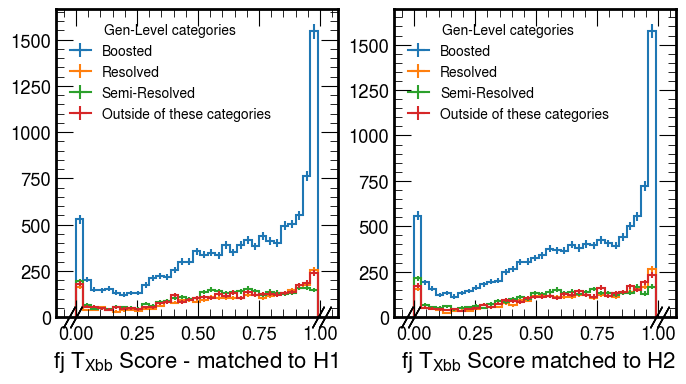

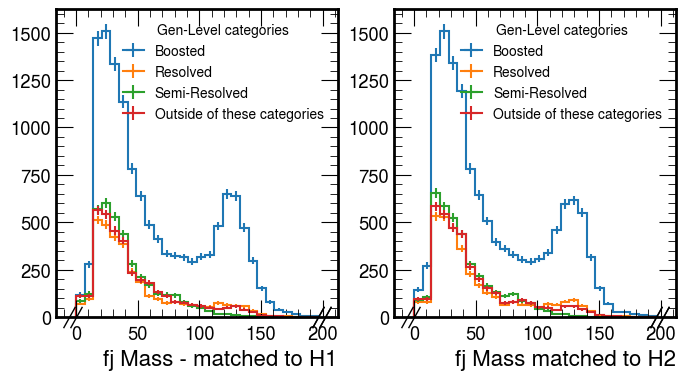

In [15]:
plot_h1h2_fj(fj_xbb, r"fj $T_{Xbb}$ Score", np.arange(0, 1, 0.03))
plot_h1h2_fj(fj_mass, r"fj Mass", np.arange(0, 200, 7))

## Tasks for billy (reco-level)

Understand behavior at gen-level of `not-categorized events` (events that are not boosted, resolved or semi-resolved):
- 2d plot of fatjet reco pnet mass vs Xbb score for each category (Are they correlated?)

In [21]:
# define a function to plot 2d histogram
plot_dir = "/uscms/home/haoyang/HH4b/plots/MatchingStudy"


def plot_hist2d(
    x_vals: np.ndarray,
    y_vals: np.ndarray,
    bins: [np.ndarray, np.ndarray],
    x_label: str,
    y_label: str,
    filename: str,
):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    for i in range(2):
        h = ax[i].hist2d(
            x_vals[:, i].reshape(-1),
            y_vals[:, i].reshape(-1),
            bins,
        )
        ax[i].set_xlabel(x_label)
        ax[i].set_ylabel(y_label)
        ax[i].set_title(f"Higgs {i + 1}")
        fig.colorbar(h[3], ax=ax[i])

    # hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
    plt.savefig(f"{plot_dir}/{filename}.jpg", bbox_inches="tight")
    plt.show()

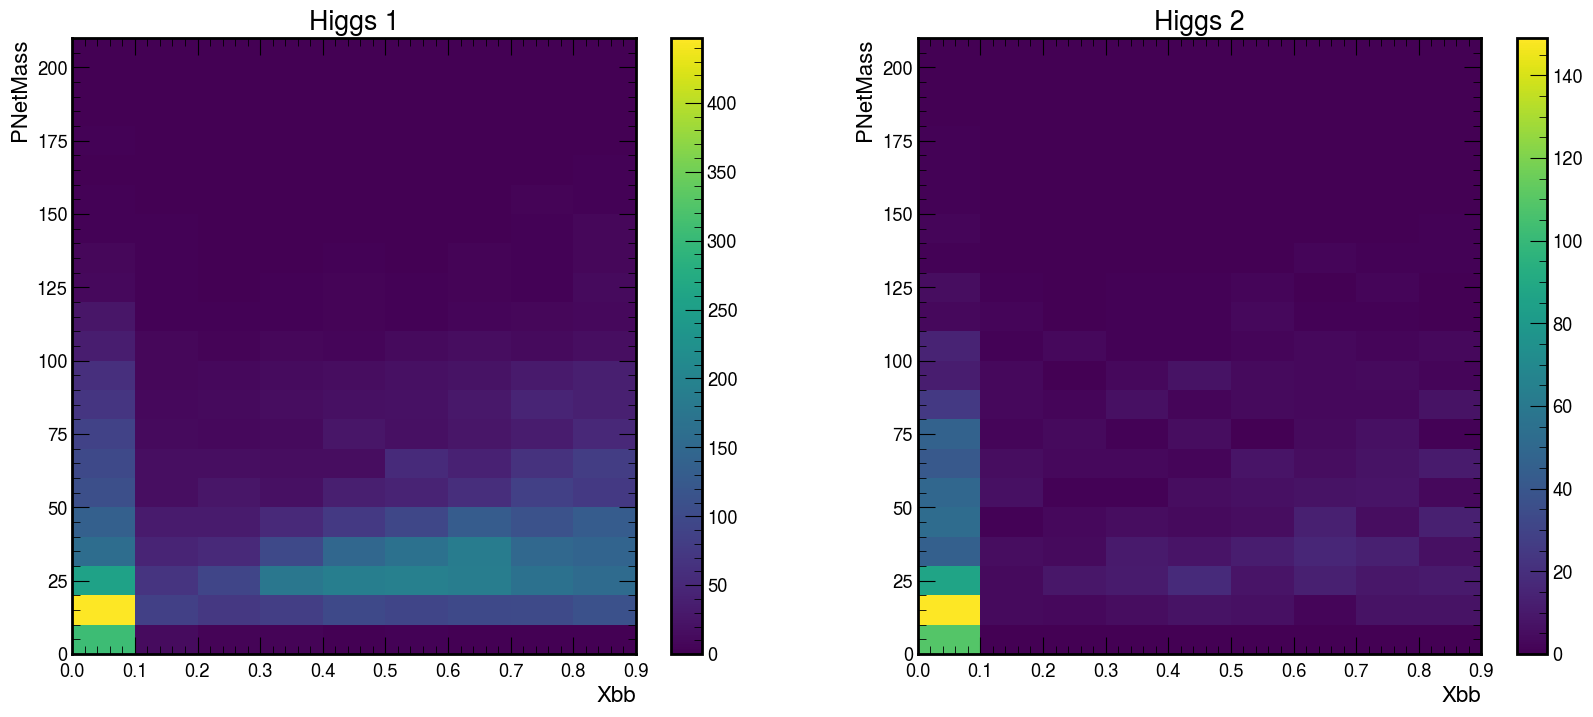

In [22]:
# get PNetMass (y) ans Xbb (x)
fjXbb = events["ak8FatJetPNetXbb"].to_numpy()
fjXbb_ooc = fjXbb[not_categorized]
fjPNetMass = events["ak8FatJetPNetMass"].to_numpy()
fjPNetMass_ooc = fjPNetMass[not_categorized]

xbins = np.arange(0, fjXbb_ooc.max(), 0.1)
ybins = np.arange(0, fjPNetMass_ooc.max(), 10)
bins = [xbins, ybins]
plot_hist2d(fjXbb_ooc, fjPNetMass_ooc, bins, "Xbb", "PNetMass", "fj_reco_PNetMass_vs_Xbb_for_ooc")

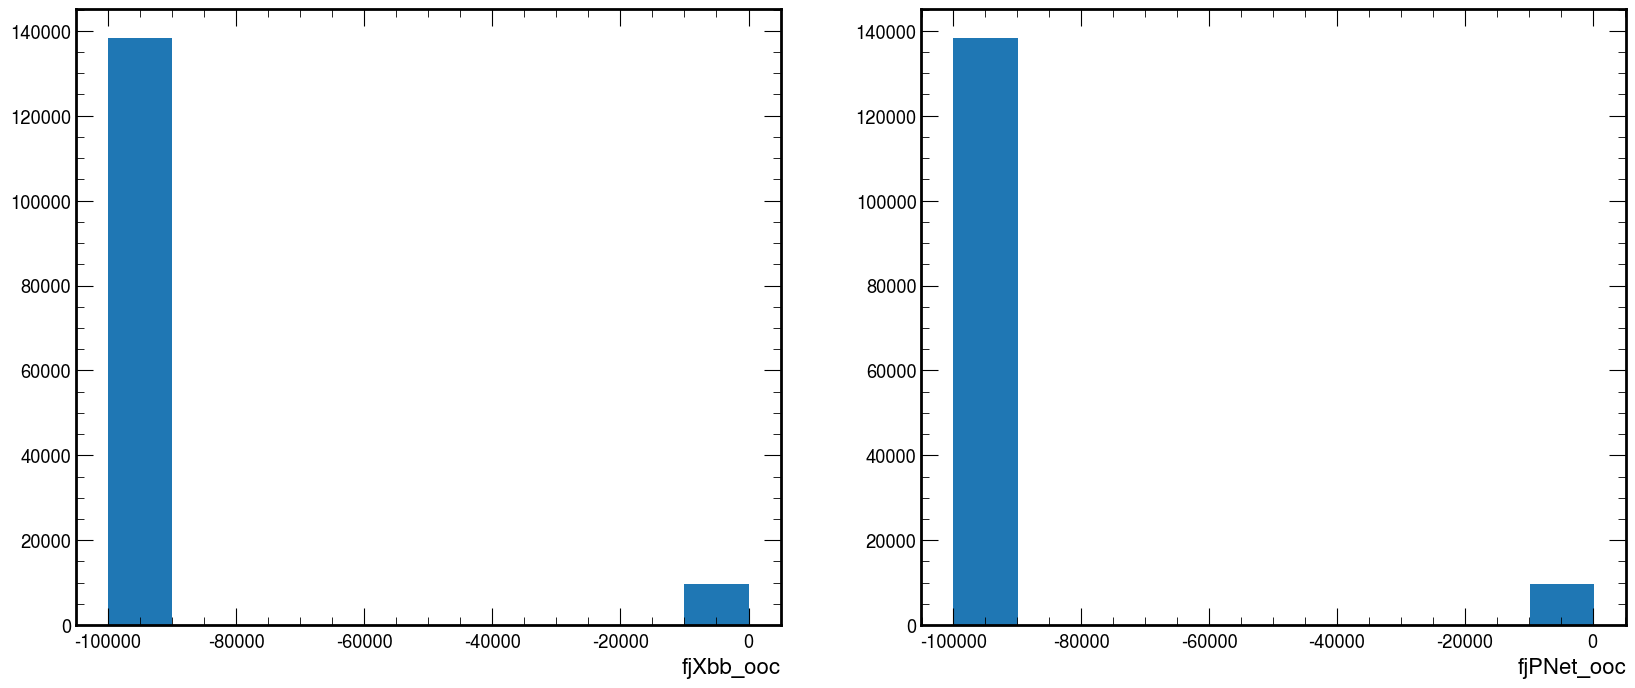

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].hist(fjXbb_ooc.reshape(-1), bins=10)
ax[1].hist(fjPNetMass_ooc.reshape(-1), bins=10)
ax[0].set(xlabel="fjXbb_ooc")
ax[1].set(xlabel="fjPNet_ooc")
plt.show()

### Billy's note: There are large negative numbers in Xbb and PNetMass.

- Plot AK8JetPNetMass and Xbb score for events that fail a tight boosted selection:
  - tight boosted selection: (fj_0_Xbb > 0.99) & (fj_0_pnet_mass > 100) & (fj_0_pnet_mass < 140>) & (fj_1_Xbb > 0.99) & (fj_1_pnet_mass > 100) & (fj_1_pnet_mass < 140>) where fj_0 and fj_1 are the fatjets in the event (sorted by Xbb, 0 has the highest Xbb score)

In [18]:
# select on ooc event's fatjets
fj0Xbb_cond = fjXbb_ooc[:, 0] > 0.99
fj0PNetMass_cond = (fjPNetMass_ooc[:, 0] > 100) & (fjPNetMass_ooc[:, 0] < 140)
fj0_cond = fj0Xbb_cond & fj0PNetMass_cond

fj1Xbb_cond = fjXbb_ooc[:, 1] > 0.99
fj1PNetMass_cond = (fjPNetMass_ooc[:, 1] > 100) & (fjPNetMass_ooc[:, 1] < 140)
fj1_cond = fj1Xbb_cond & fj1PNetMass_cond

tight = fj0_cond & fj1_cond

fjPNetMass_fail = fjPNetMass_ooc[~tight].reshape(-1)
fjXbb_fail = fjXbb_ooc[~tight].reshape(-1)

[Text(1, 0, 'failed ooc fjPNetMass')]

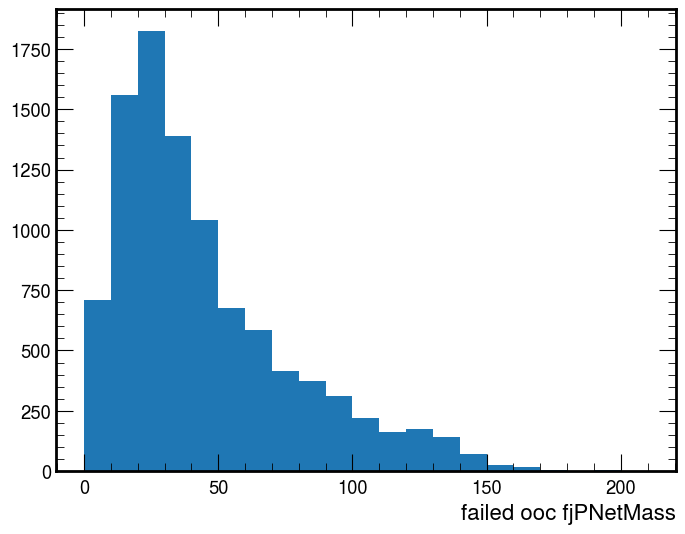

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(fjPNetMass_fail, bins=ybins)
ax.set(xlabel="failed ooc fjPNetMass")

[Text(1, 0, 'failed ooc fjXbb')]

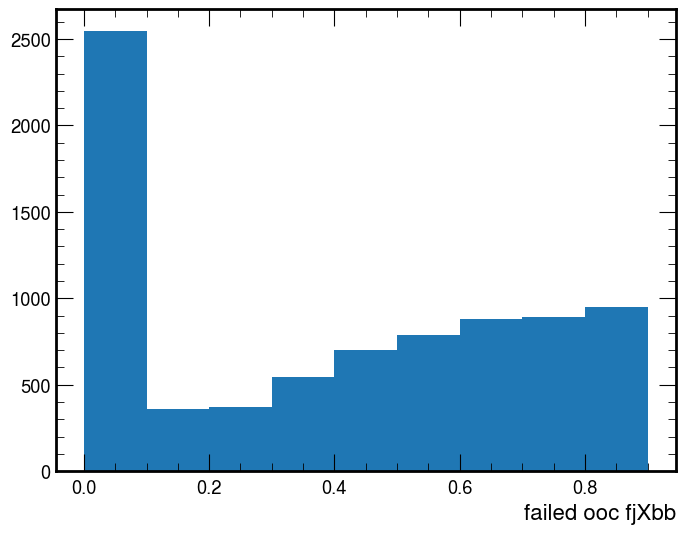

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(fjXbb_fail, bins=xbins)
ax.set(xlabel="failed ooc fjXbb")